## An IR Evaluation Scenario

For a <b>particular query</b>, there are 20 relevant documents. 

Two IR systems, namely System 1 and System 2, have retrieved lists of 50 and 40 ranked documents respectively for this query. 

In [1]:
#relevant = set([2, 8, 13, 28, 55, 101, 145, 147, 303, 321, 332, 441, 489, 491, 702, 812, 876, 898, 945, 987])
relevant = set([28, 55, 101, 145, 147, 303, 321, 332, 441, 489, 491, 702, 812, 876, 898, 945, 987])

ranked1 = [101, 189, 8, 812, 834, 234, 145, 303, 456, 332, 554, \
          981, 702, 987, 50, 2, 13, 345, 999, 489, 898, 55, 28, 87, 102, \
         441, 147, 324, 945, 827, 333, 294, 111, 304, 877, 656, 222, \
          910, 876, 321, 491, 783, 700, 935, 320, 400, 6, 9, 399, 44]

ranked2 = [28, 55, 277, 101, 145, 99, 738,147, 892, 11,303, 321, 332, \
          491, 702, 812, 876, 234, 783, 391, 898, 945,\
          829, 109, 78]

tail = [2993, 2, 288932, 8, 382773, 13, 28882, 18839, 441, 882901, 882, 18882, 987, 8783, 489]
ranked2.extend(tail)

print("There are", len(relevant), "relevant documents.")
print("System 1 has returned a ranked list of", len(ranked1), "documents.")
print("System 2 has returned a ranked list of", len(ranked2), "documents.")

There are 17 relevant documents.
System 1 has returned a ranked list of 50 documents.
System 2 has returned a ranked list of 40 documents.


The following two cells are just to validate that the example constructed (by hand) is what we want.

Firstly, our ranked results should not have any duplicates. 

In [2]:
# This is for a preliminary checking 
def checkduplicate(ranked):
    uni = {}
    for docid in ranked:
        if uni.get(docid, -1) == 1:
            print("DocId", docid, "is duplicate in the ranked list.")
        else:
            uni[docid] = 1

checkduplicate(ranked1)
checkduplicate(ranked2)

# If nothing is printed, we are okay to go.

Also, for this example, we want that all relevant documents are returned by System 1 so that it reaches recall 100\%. 

In [3]:
for docid in relevant:
    if docid not in ranked2:
        print("Attention!\nDocID", docid, "is not returned by the system at all.")
        
# If nothing is printed, we are okay to go. 

## Unranked precision and recall

If the results were <b>not ranked</b>, we can measure overall precision and recall of the systems (for this particular query).

$\large\mathrm{Precision} = \frac{\text{number of relevant docs retrieved}}{\text{number of total docs retrieved}} = P(\text{relevant}|\text{retrieved})$.

$\large\mathrm{Recall} = \frac{\text{number of relevant docs retrieved}}{\text{number of relevant docs}} = P(\text{retrieved}|\text{relevant})$.

Let us calculate the precision and recall achieved by the two systems. 

In [4]:
def precisionAndRecall(retrieved, relevant):
    count = len(set(retrieved).intersection(relevant))
    return count / len(retrieved), count / len(relevant)

p1, r1 = precisionAndRecall(ranked1, relevant)
p2, r2 = precisionAndRecall(ranked2, relevant)

print("System 1: precision =", p1, ", Recall =", r1)
print("System 2: precision =", p2, ", Recall =", r2)

System 1: precision = 0.34 , Recall = 1.0
System 2: precision = 0.425 , Recall = 1.0


## Understanding precision and recall 

<b>True positive </b>($tp$): Actually relevant (positive) and retrieved (determined as relevant / positive). <br>
<b>False positive </b>($fp$): Actually not relevant (negative), but retrieved (determined as relevant / positive). <br>
<b>True negative </b>($tn$): Actually not relevant (negative) and not retrieved (determined as not relevant / negative).<br>
<b>False negative </b>($fn$): Actually relevant (positive), but not retrieved (determined as not relevant / negative).

<table>
    <tr>
        <td></td><td>Relevant</td><td>Not relevant</td>
    </tr>
    <tr>
        <td>Retrieved</td><td>$tp$</td><td>$fp$</td>
    </tr>
    <tr>
        <td>Not retrieved</td><td>$fn$</td><td>$tn$</td>
    </tr>
</table>

Then, we have $ P = \frac{tp}{tp + fp}$ and $R = \frac{tp}{tp + fn}$.

<b>Precision</b> is also called the <b>accuracy</b>, particularly for unranked determination tasks (such as classification). 

## F-measure (tradeoff precision and recall)

Weighted harmonic mean of precision and recall. 

Balanced F-mesure: $F = \large\frac{2PR}{P+R}$.

General formula: $F = \large\frac{1}{\alpha \frac{1}{P} + (1 - \alpha) \frac{1}{R}}$, for some $\alpha \in [0,1]$.

Alternative formula: $F =\large\frac{(\beta^2 + 1)PR}{\beta^2 P+R}$, where $\beta^2 = \large\frac{1 - \alpha}{\alpha}$.

The balanced F-measure is the special case when $\alpha = 1/2$ and $\beta = 1$. 

For $\beta < 1$, we emphasize precision. For $\beta > 1$, we emphasize recall. 

Let us compute the F-measures of the two systems in our example. 

In [5]:
F1 = 2*p1*r1/(p1+r1)
F2 = 2*p2*r2/(p2+r2)

print("System 1: precision =", p1, ", Recall =", r1, ", F-measure =", "%.2f"%F1)
print("System 2: precision =", p2, ", Recall =", r2, ", F-measure =",  "%.2f"%F2)

System 1: precision = 0.34 , Recall = 1.0 , F-measure = 0.51
System 2: precision = 0.425 , Recall = 1.0 , F-measure = 0.60


## Evaluation of ranked retrieval results

Two systems may have the same precision overall, but one of them may perform a better ranking. The goal is to retrieve more relevant documents as top-ranked results. 

### Precision and recall at $k$ retrieved documents (Prec@$k$, Recall@$k$)

Let us consider the ranked results from the beginning while calculating precision and recall at each document retrieved.

In [6]:
def rankedEvaluation(ranked, relevant):
    precs = []
    recalls = []
    tp = 0
    
    print("Rank\tDocID\tRel\tPrec\tRecall")
    for k in range(len(ranked)):
        ans = "N"
        if ranked[k] in relevant:
            tp += 1
            ans = "Y"
        P = tp/(k+1)
        R = tp/len(relevant)
        precs.append(P)
        recalls.append(R)
        print((k+1), "\t", ranked[k], "\t", ans, "\t",  "%.2f"%P, "\t",  "%.2f"%R)
    return precs, recalls

In [7]:
precs1, recalls1 = rankedEvaluation(ranked1, relevant)

Rank	DocID	Rel	Prec	Recall
1 	 101 	 Y 	 1.00 	 0.06
2 	 189 	 N 	 0.50 	 0.06
3 	 8 	 N 	 0.33 	 0.06
4 	 812 	 Y 	 0.50 	 0.12
5 	 834 	 N 	 0.40 	 0.12
6 	 234 	 N 	 0.33 	 0.12
7 	 145 	 Y 	 0.43 	 0.18
8 	 303 	 Y 	 0.50 	 0.24
9 	 456 	 N 	 0.44 	 0.24
10 	 332 	 Y 	 0.50 	 0.29
11 	 554 	 N 	 0.45 	 0.29
12 	 981 	 N 	 0.42 	 0.29
13 	 702 	 Y 	 0.46 	 0.35
14 	 987 	 Y 	 0.50 	 0.41
15 	 50 	 N 	 0.47 	 0.41
16 	 2 	 N 	 0.44 	 0.41
17 	 13 	 N 	 0.41 	 0.41
18 	 345 	 N 	 0.39 	 0.41
19 	 999 	 N 	 0.37 	 0.41
20 	 489 	 Y 	 0.40 	 0.47
21 	 898 	 Y 	 0.43 	 0.53
22 	 55 	 Y 	 0.45 	 0.59
23 	 28 	 Y 	 0.48 	 0.65
24 	 87 	 N 	 0.46 	 0.65
25 	 102 	 N 	 0.44 	 0.65
26 	 441 	 Y 	 0.46 	 0.71
27 	 147 	 Y 	 0.48 	 0.76
28 	 324 	 N 	 0.46 	 0.76
29 	 945 	 Y 	 0.48 	 0.82
30 	 827 	 N 	 0.47 	 0.82
31 	 333 	 N 	 0.45 	 0.82
32 	 294 	 N 	 0.44 	 0.82
33 	 111 	 N 	 0.42 	 0.82
34 	 304 	 N 	 0.41 	 0.82
35 	 877 	 N 	 0.40 	 0.82
36 	 656 	 N 	 0.39 	 0.82
37 	 222 	 N 	 0.38

In [8]:
precs2, recalls2 = rankedEvaluation(ranked2, relevant)

Rank	DocID	Rel	Prec	Recall
1 	 28 	 Y 	 1.00 	 0.06
2 	 55 	 Y 	 1.00 	 0.12
3 	 277 	 N 	 0.67 	 0.12
4 	 101 	 Y 	 0.75 	 0.18
5 	 145 	 Y 	 0.80 	 0.24
6 	 99 	 N 	 0.67 	 0.24
7 	 738 	 N 	 0.57 	 0.24
8 	 147 	 Y 	 0.62 	 0.29
9 	 892 	 N 	 0.56 	 0.29
10 	 11 	 N 	 0.50 	 0.29
11 	 303 	 Y 	 0.55 	 0.35
12 	 321 	 Y 	 0.58 	 0.41
13 	 332 	 Y 	 0.62 	 0.47
14 	 491 	 Y 	 0.64 	 0.53
15 	 702 	 Y 	 0.67 	 0.59
16 	 812 	 Y 	 0.69 	 0.65
17 	 876 	 Y 	 0.71 	 0.71
18 	 234 	 N 	 0.67 	 0.71
19 	 783 	 N 	 0.63 	 0.71
20 	 391 	 N 	 0.60 	 0.71
21 	 898 	 Y 	 0.62 	 0.76
22 	 945 	 Y 	 0.64 	 0.82
23 	 829 	 N 	 0.61 	 0.82
24 	 109 	 N 	 0.58 	 0.82
25 	 78 	 N 	 0.56 	 0.82
26 	 2993 	 N 	 0.54 	 0.82
27 	 2 	 N 	 0.52 	 0.82
28 	 288932 	 N 	 0.50 	 0.82
29 	 8 	 N 	 0.48 	 0.82
30 	 382773 	 N 	 0.47 	 0.82
31 	 13 	 N 	 0.45 	 0.82
32 	 28882 	 N 	 0.44 	 0.82
33 	 18839 	 N 	 0.42 	 0.82
34 	 441 	 Y 	 0.44 	 0.88
35 	 882901 	 N 	 0.43 	 0.88
36 	 882 	 N 	 0.42 	 0.88
37 	 1

## The precision-recall curve

We can plot the (recall, precision) points in a curve, called the <b>precision-recall curve</b>.

(0.0, 1.1, -0.1, 1.1)

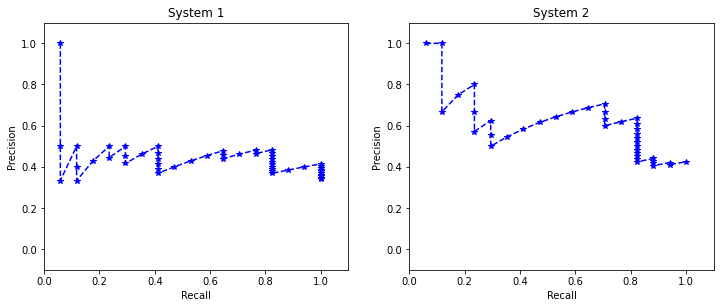

In [9]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
plt.subplot(221)
plt.title('System 1')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.plot(recalls1, precs1, 'b--*')
plt.axis([0, 1.1, -0.1, 1.1])
plt.subplot(222)
plt.title('System 2')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.plot(recalls2, precs2, 'b--*')
plt.axis([0, 1.1, -0.1, 1.1])

<b>Note:</b> Such a curve can have a saw-tooth shape, because 
* If a retrieved document is relevant, both precision and recall goes up, so the curve jags up to the right.
* If a retrieved document is not relevant, then recall remains the same (no new relevant document retrieved), but the precision drops, so the curve falls directly towards the bottom. 

## Interpolated precision

* Idea 1: calculate only at points where the recall is changing (recall can only increase).
* Idea 2: make sure that the precision does not increase with recall. 

The interpolated precision $P_{\text{interp}}(r)$ at a certain recall level $r$ is defined as the highest precision for any recall $r' > r$.

$P_{\text{interp}}(r) = \max_{r' \geq r} P(r)$.

In [10]:
def interpolated_precisions(ranked, precs, recalls):
    interp_precs = []
    interp_recalls = []
    ranks = []
    # Initialize R = -1 so that the first doc retrieved changes the recall
    R = -1
    print("Rank\tDocID\tRel\tPrec\tRecall\tInt.Prec")
    for k in range(len(recalls)):
        if recalls[k] > R:
            iP = max(precs[k:])
            R = recalls[k]
            interp_precs.append(iP)
            interp_recalls.append(recalls[k])
            ranks.append(k)
            print((k+1), "\t", ranked[k], "\t", "Y", "\t",  "%.2f"%precs[k], "\t",  "%.2f"%R, "\t", "%.2f"%iP)
        else:
            print((k+1), "\t", ranked[k], "\t", "N", "\t",  "%.2f"%precs[k], "\t",  "%.2f"%R)
    return ranks, interp_precs, interp_recalls

In [11]:
ranks1, iPs1, iRs1 = interpolated_precisions(ranked1, precs1, recalls1)

Rank	DocID	Rel	Prec	Recall	Int.Prec
1 	 101 	 Y 	 1.00 	 0.06 	 1.00
2 	 189 	 N 	 0.50 	 0.06
3 	 8 	 N 	 0.33 	 0.06
4 	 812 	 Y 	 0.50 	 0.12 	 0.50
5 	 834 	 N 	 0.40 	 0.12
6 	 234 	 N 	 0.33 	 0.12
7 	 145 	 Y 	 0.43 	 0.18 	 0.50
8 	 303 	 Y 	 0.50 	 0.24 	 0.50
9 	 456 	 N 	 0.44 	 0.24
10 	 332 	 Y 	 0.50 	 0.29 	 0.50
11 	 554 	 N 	 0.45 	 0.29
12 	 981 	 N 	 0.42 	 0.29
13 	 702 	 Y 	 0.46 	 0.35 	 0.50
14 	 987 	 Y 	 0.50 	 0.41 	 0.50
15 	 50 	 N 	 0.47 	 0.41
16 	 2 	 N 	 0.44 	 0.41
17 	 13 	 N 	 0.41 	 0.41
18 	 345 	 N 	 0.39 	 0.41
19 	 999 	 N 	 0.37 	 0.41
20 	 489 	 Y 	 0.40 	 0.47 	 0.48
21 	 898 	 Y 	 0.43 	 0.53 	 0.48
22 	 55 	 Y 	 0.45 	 0.59 	 0.48
23 	 28 	 Y 	 0.48 	 0.65 	 0.48
24 	 87 	 N 	 0.46 	 0.65
25 	 102 	 N 	 0.44 	 0.65
26 	 441 	 Y 	 0.46 	 0.71 	 0.48
27 	 147 	 Y 	 0.48 	 0.76 	 0.48
28 	 324 	 N 	 0.46 	 0.76
29 	 945 	 Y 	 0.48 	 0.82 	 0.48
30 	 827 	 N 	 0.47 	 0.82
31 	 333 	 N 	 0.45 	 0.82
32 	 294 	 N 	 0.44 	 0.82
33 	 111 	 N 	 0.42 

In [12]:
ranks2, iPs2, iRs2 = interpolated_precisions(ranked2, precs2, recalls2)

Rank	DocID	Rel	Prec	Recall	Int.Prec
1 	 28 	 Y 	 1.00 	 0.06 	 1.00
2 	 55 	 Y 	 1.00 	 0.12 	 1.00
3 	 277 	 N 	 0.67 	 0.12
4 	 101 	 Y 	 0.75 	 0.18 	 0.80
5 	 145 	 Y 	 0.80 	 0.24 	 0.80
6 	 99 	 N 	 0.67 	 0.24
7 	 738 	 N 	 0.57 	 0.24
8 	 147 	 Y 	 0.62 	 0.29 	 0.71
9 	 892 	 N 	 0.56 	 0.29
10 	 11 	 N 	 0.50 	 0.29
11 	 303 	 Y 	 0.55 	 0.35 	 0.71
12 	 321 	 Y 	 0.58 	 0.41 	 0.71
13 	 332 	 Y 	 0.62 	 0.47 	 0.71
14 	 491 	 Y 	 0.64 	 0.53 	 0.71
15 	 702 	 Y 	 0.67 	 0.59 	 0.71
16 	 812 	 Y 	 0.69 	 0.65 	 0.71
17 	 876 	 Y 	 0.71 	 0.71 	 0.71
18 	 234 	 N 	 0.67 	 0.71
19 	 783 	 N 	 0.63 	 0.71
20 	 391 	 N 	 0.60 	 0.71
21 	 898 	 Y 	 0.62 	 0.76 	 0.64
22 	 945 	 Y 	 0.64 	 0.82 	 0.64
23 	 829 	 N 	 0.61 	 0.82
24 	 109 	 N 	 0.58 	 0.82
25 	 78 	 N 	 0.56 	 0.82
26 	 2993 	 N 	 0.54 	 0.82
27 	 2 	 N 	 0.52 	 0.82
28 	 288932 	 N 	 0.50 	 0.82
29 	 8 	 N 	 0.48 	 0.82
30 	 382773 	 N 	 0.47 	 0.82
31 	 13 	 N 	 0.45 	 0.82
32 	 28882 	 N 	 0.44 	 0.82
33 	 18839 	

### Interpolated precision - recall curve

So, we can plot the interpolated precision against recall. 

(0.0, 1.1, -0.1, 1.1)

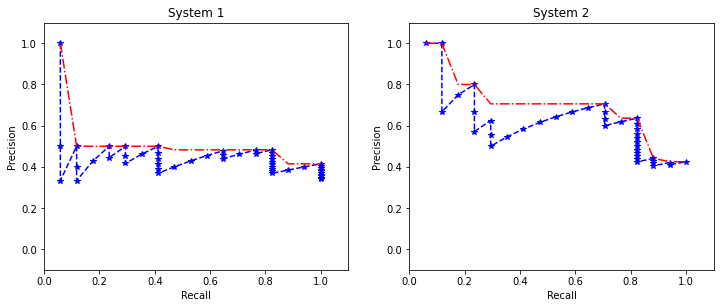

In [13]:
plt.figure(figsize=(12, 10))
plt.subplot(221)
plt.title('System 1')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.plot(recalls1, precs1, 'b--*')
plt.plot(iRs1, iPs1, 'r-.')
plt.axis([0, 1.1, -0.1, 1.1])
plt.subplot(222)
plt.title('System 2')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.plot(recalls2, precs2, 'b--*')
plt.plot(iRs2, iPs2, 'r-.')
plt.axis([0, 1.1, -0.1, 1.1])